# Engineering Wind Farm Models Object

In this example, all the engineering models that PyWake uses for the wake definition and calculation are explained. All wind farm models take a `Site` and a `WindTurbines` object as input.

**Install PyWake if needed**

In [ ]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Model overview

<center><img src="../_static/EngineeringModels.svg"/></center>

The engineering wind farms models in PyWake are composed of one of two wind farms models in combination with a wake deficit model, a [superposition model](#Superposition-models) and optionally a [blockage deficit](#Blockage-deficit-models) and a [turbulence model](#Turbulence-models). In addition, a [rotor average model](#Rotor-average-models) , a [deflection model](#Deflection-models) and a [ground model](#Ground-models) are also available.

A brief definition of each can be found in the [Overview](./Overview.ipynb) section. 

## Predefined WindFarmModels
**The deficit models comprise:**

| Name | WindFarmModel | Wake DeficitModel | Blockage DeficitModel | SuperpositionModel |
| :--- | :--- | :--- | :--- | :--- | 
| NOJ | [PropagateDownwind](#PropagateDownwind) | [NOJDeficit](#NOJDeficit) | - | [SquaredSum](#SquaredSum) |
| Fuga | [PropagateDownwind](#PropagateDownwind) | [FugaDeficit](#FugaDeficit) | - | [LinearSum](#LinearSum) |
| FugaBlockage | [All2AllIterative](#All2AllIterative) | [FugaDeficit](#FugaDeficit) | [FugaDeficit](#FugaDeficit) | [LinearSum](#LinearSum) |
| BastankhahGaussian | [PropagateDownwind](#PropagateDownwind) | [BastankhahGaussianDeficit](#BastankhahGaussianDeficit) | - | [SquaredSum](#SquaredSum) |
| IEA37SimpleBastankhahGaussian | [PropagateDownwind](#PropagateDownwind) | [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit) | - | [SquaredSum](#SquaredSum) |

- Default rotor-average model: `RotorCenter`
- Default turbulence model: `None`

**First we import basic Python and PyWake elements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

## Engineering WindFarmModel base classes

### PropagateDownwind

The `PropagateDownwind` wind farm model is very fast as it only performs a minimum of deficit calculations. It iterates over all turbines in downstream order. In each iteration it calculates the effective wind speed at the current wind turbine as the free stream wind speed minus the sum of the deficit from upstream sources. Based on this effective wind speed, it calculates the deficit caused by the current turbine on all downstream destinations. Note, that this procedure neglects upstream blockage effects.

```python

for wt in wind turbines in downstream order:
    ws_eff[wt] = ws[wt] - superposition(deficit[from_upstream_src,to_wt])
    ct = windTurbines.ct(ws_eff[wt])
    deficit[from_wt,to_downstream_dst] = wakeDeficitModel(ct, distances[from_wt,to_downstream_dst], ...)
```

The proceedure is illustrated in the animation below:

- **Iteration 1:** WT0 sees the free wind (10m/s). Its deficit on WT1 and WT2 is calculated.
- **Iteration 2:** WT1 sees the free wind minus the deficit from WT0. Its deficit on WT2 is calculated and the effective wind speed at WT2 is updated.

![PropagateDownwind](../_static/PropagateDownwind.gif)

### All2AllIterative

The `All2AllIterative` wind farm model is slower but is capable of handling blockage effects. It iterates until the effective wind speed converges (i.e. less than or equal to the maximum number of turbines that affect each other in the wind farm. The converge tolerance is an input parameter. In each iteration it sums up the deficit from all wind turbine sources and calculates the deficit caused by the all wind turbines turbine on all wind turbines.

```python

while ws_eff not converged:
    ws_eff[all] = ws[all] - superposition(deficit[from_all,to_all])
    ct[all] = windTurbines.ct(ws_eff[all])
    deficit[from_all,to_all] = wakeDeficitModel(ct[all], distances[from_all,to_all], ...)
```

The proceedure is illustrated in the animation below:

- **Iteration 1:** All three WT see the free wind (10m/s) and their CT values and resulting deficits are therefore equal.
- **Iteration 2:** The local effective wind speeds are updated taking into account the wake and blockage effects of the other WT. Based on these wind speeds the CT and deficits are recalculated.
- **Iteration 3:** Repeat after which the flow field has converged.

![All2AllIterative](../_static/All2AllIterative.gif)

## Wake deficit models
The wake deficit models compute the wake deficit caused by a single wind turbine. In PyWake, there are several wake deficit models, which include:

- [NOJDeficit](#NOJDeficit)
- [TurboNOJDeficit](#TurboNOJDeficit)
- [FugaDeficit](#FugaDeficit)
- [BastankhahGaussianDeficit](#BastankhahGaussianDeficit)
- [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit)
- [NiayifarGaussianDeficit](#NiayifarGaussianDeficit)
- [ZongGaussianDeficit](#ZongGaussianDeficit)
- [CarbajofuertesGaussianDeficit](#CarbajofuertesGaussianDeficit)
- [TurboGaussianDeficit](#TurboGaussianDeficit)
- [GCLDeficit](#GCLDeficit)

**Note**: The implementation of the deficit models is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: source wind turbines
- j: destination wind turbines
- k: wind speeds
- l: wind directions

**This means that** `deficit_ijlk[0,1,2,3]` **holds the deficit caused by the first turbine on the second turbine for the third  wind direction and fourth wind speed**.

In [2]:
#here we import all wake deficit models available in PyWake
from py_wake import NOJ
from py_wake import Fuga
from py_wake import FugaBlockage
from py_wake import BastankhahGaussian

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

models = {'NOJ': NOJ(site,windTurbines), 
          'Fuga': Fuga(lut_path,site,windTurbines),
          'FugaBlockage': FugaBlockage(lut_path,site,windTurbines), 
          'BGaus': BastankhahGaussian(site,windTurbines)
         }

In addition, these models can easily be combined with other models to better describe the wake behind the turbine, e.g. NOJ with linear sum superposition:

In [3]:
from py_wake.superposition_models import LinearSum

models['NOJLinear'] = NOJ(site,windTurbines,superpositionModel=LinearSum())

Or models can be combined in custom ways, e.g. `NOJDeficit` for the wake, `LinearSum` superposition and `SelfSimilarityDeficit` for the blockage:

In [4]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit

models['NOJ_ss'] = All2AllIterative(site,windTurbines,
                                          wake_deficitModel=NOJDeficit(),
                                          superpositionModel=LinearSum(), 
                                          blockage_deficitModel=SelfSimilarityDeficit())

###  Wake Deficit Models - definition and configuration

First, we create some functions to visualize wake maps for different conditions and wake models.

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.deficit_models import BastankhahGaussianDeficit

#turbine diameter
D = 80

def _map(model, xy=None, method='calc_deficit'):
    X, Y = np.meshgrid(*xy)
    x_j, y_j = X.flatten(), Y.flatten()
    ws = 10
    downwind_distance_ijlk = x_j.reshape((1, -1, 1, 1))
    crosswind_distance_ijlk = np.abs(y_j.reshape((1, -1, 1, 1)))
    kwargs = dict(
        # specify arguments for all models
        WS_ilk=np.array([[[ws]]]),                      # wind speed at source turbine
        D_src_il=np.array([[D]]),                       # diameter of source turbine
        D_dst_ijl=None,                                 # diameter of destination turbine
        h_ilk=np.array([[[67]]]),                          # source turbine hub height
        dw_ijlk=downwind_distance_ijlk,                 # down wind distance
        hcw_ijlk=crosswind_distance_ijlk,               # horizontal cross wind distance
        # height difference(vertical cross wind distance) between source and destination turbine
        dh_ijlk=np.zeros_like(downwind_distance_ijlk),
        z_ijlk=np.zeros_like(downwind_distance_ijlk)+67,
        cw_ijlk=crosswind_distance_ijlk,                # cross wind distance (both horizontal and vertical)
        ct_ilk=np.array([[[8 / 9]]]),                   # thrust coefficient
        WS_eff_ilk=np.array([[[ws]]]),                  # effective wind speed at source turbine
        TI_ilk=np.array([[[0.1]]]),                     # turbulence intensity at source turbine
        TI_eff_ilk=np.array([[[0.1]]]),                 # effective turbulence intensity at source turbine
        yaw_ilk=np.array([[[0.1]]]))                    # yaw angle at source turbine
    
    try:  # fails if wake_radius is not implemented in the deficit model
        kwargs['wake_radius_ijlk'] = model.wake_radius(**kwargs)
    except Exception:
        kwargs['wake_radius_ijlk'] = NOJDeficit().wake_radius(**kwargs)
    kwargs['wake_radius_ijl'] = kwargs['wake_radius_ijlk'][..., 0]
    
    res_ijlk = getattr(model, method)(**kwargs)
    return X / D, Y / D, res_ijlk[0, :, 0, 0].reshape(X.shape)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0,10,55)):
    xy = np.linspace(-200,500,200), np.linspace(-200,200,200)
    X,Y,deficit = _map(model, xy)
    c = plt.contourf(X,Y,deficit, levels=levels, cmap=cmap)
    plt.colorbar(c, label="Deficit [m/s]")
    plt.plot([0,0],[-1/2,1/2],'k')
    plt.ylabel("Crosswind distance [y/D]")
    plt.xlabel("downwind distance [x/D]")

def plot_wake_deficit_map(model):
    cmap = np.r_[[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap))

def plot_blockage_deficit_map(model):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap), levels=np.linspace(-3.5,3.5,113))


### NOJDeficit

The NOJDeficit model is implemented according to Niels Otto Jensen, "A note on wind generator interaction." (1983), i.e. a top-hat wake.

Only valid in the far wake.


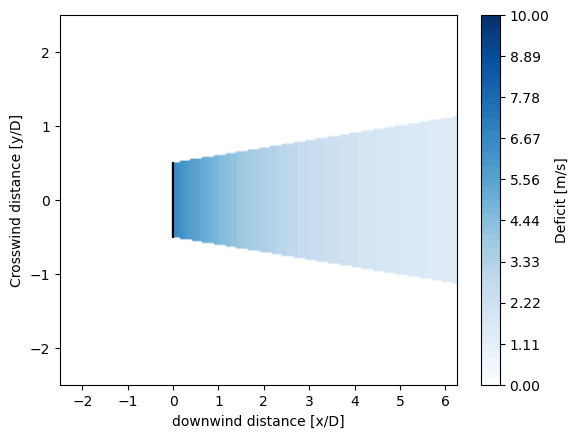

In [6]:
from py_wake.deficit_models import NOJDeficit
plot_wake_deficit_map(NOJDeficit())

### TurboNOJDeficit

Modified definition of the wake expansion given by Nygaard [1], which assumes the wake expansion rate to be proportional to the local turbulence intensity in the wake. Here the local turbulence intensity is defined as the combination of ambient and wake added turbulence. Using the added wake turbulence model by Frandsen and integrating, an analytical expression for the wake radius can be obtained.

The definition in [1] of ambient turbulence is the free-stream TI and for this the model constant A has been tuned, however a fully consistent formulation of the model should probably use the locally effective TI, which includes the added turbulence from upstream turbines. 

[1] Nygaard 2020 J. Phys.: Conf. Ser. 1618 062072 https://doi.org/10.1088/1742-6596/1618/6/062072

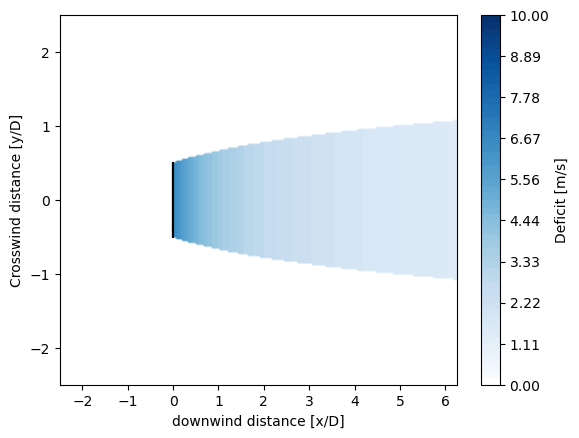

In [7]:
from py_wake.deficit_models import TurboNOJDeficit
plot_wake_deficit_map(TurboNOJDeficit())

### FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set of look-up tables computed by a linearized RANS solver. The look-up tables are created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The FugaDeficit model can model the near wake, far wake and blockage deficit.

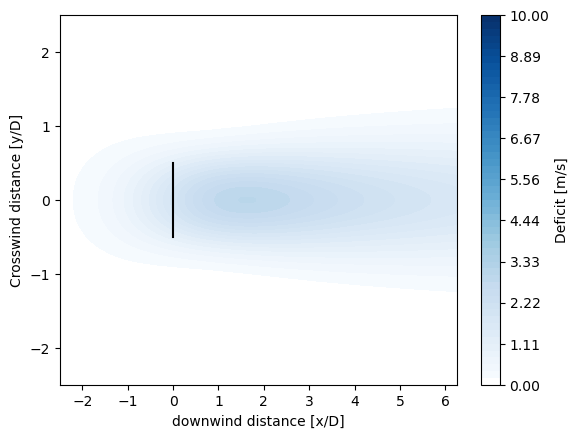

In [8]:
import py_wake
from py_wake.deficit_models import FugaDeficit

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

plot_wake_deficit_map(FugaDeficit(lut_path))

### BastankhahGaussianDeficit

The BastankhahGaussianDeficit model is implemented according to Bastankhah M and Porté-Agel F. "A new analytical model for wind-turbine wakes" J. Renew. Energy. 2014;70:116-23.

The model is valid in the far wake only.

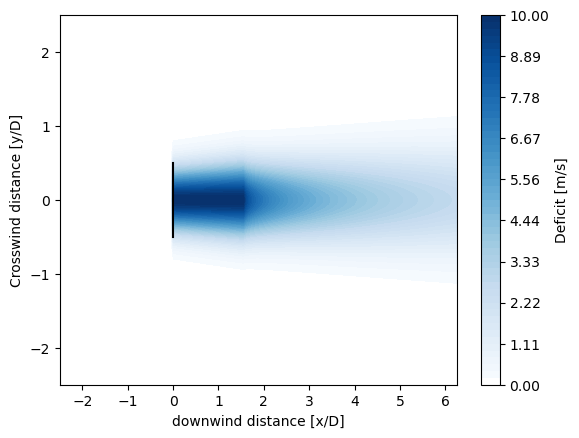

In [9]:
from py_wake.deficit_models import BastankhahGaussianDeficit
plot_wake_deficit_map(BastankhahGaussianDeficit())

### IEA37SimpleBastankhahGaussianDeficit

The IEA37SimpleBastankhahGaussianDeficit model is implemented according to the [IEA task 37 documentation](https://github.com/byuflowlab/iea37-wflo-casestudies/blob/master/cs1-2/iea37-wakemodel.pdf) and is equivalent to BastankhahGaussianDeficit for $beta=1/\sqrt{8} \sim ct=0.9637188$.

The model is valid in the far wake only.

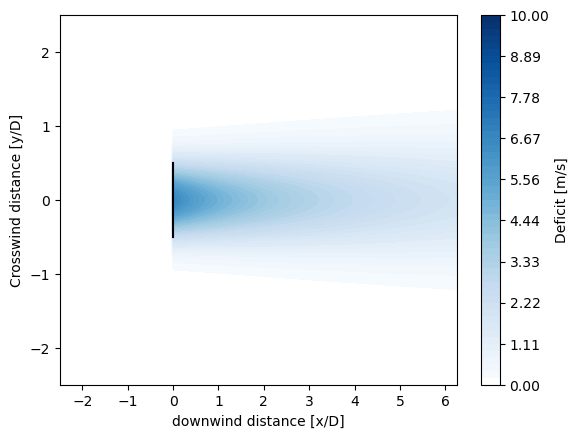

In [10]:
from py_wake.deficit_models import IEA37SimpleBastankhahGaussianDeficit
plot_wake_deficit_map(IEA37SimpleBastankhahGaussianDeficit())

### NiayifarGaussianDeficit

This wake deficit model accounts for the local turbulence intensity when evaluating the wake expansion. The expansion rate 'k' varies linearly with local turbluence intensity: k = a1 I + a2. The default constants are set according to publications by Porte-Agel's group, which are based on LES simulations. Lidar field measurements by Fuertes et al. (2018) indicate that a = [0.35, 0.0] is also a valid selection.

It was implemented according to: Amin Niayifar and Fernando Porté-Agel, Analytical Modeling of Wind Farms: A New Approach for Power Prediction, Energies 2016, 9, 741; doi:10.3390/en9090741.

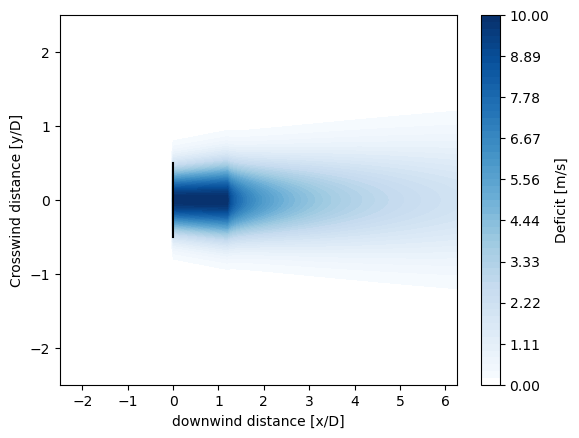

In [11]:
from py_wake.deficit_models import NiayifarGaussianDeficit
plot_wake_deficit_map(NiayifarGaussianDeficit(a=[0.38, 4e-3]))

### ZongGaussianDeficit

The wake expansion is also function of the local turbulence intensity and the wake width expression now follows the approach by Shapiro et al. (2018). It is an extension of the Niayifar et al. (2016) model implementation with the addition of the new wake width expression, which uses the near-wake length estimation by Vermeulen (1980).

It was implemented according to: Haohua Zong and Fernando Porté-Agel, A momentum-conserving wake superposition method for wind farm power prediction, J. Fluid Mech. (2020), vol. 889, A8; doi:10.1017/jfm.2020.77.

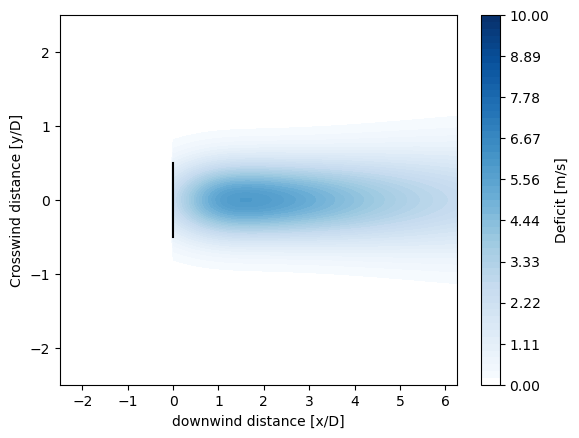

In [12]:
from py_wake.deficit_models import ZongGaussianDeficit
plot_wake_deficit_map(ZongGaussianDeficit(a=[0.38, 4e-3]))

### CarbajoFuertesGaussianDeficit

Carbajo Fuertes et al. derived Gaussian wake model parameters from nacelle liadar measurements from a 2.5MW turbine and found a
variation of epsilon with wake expansion, this in fact identical to the formulation by Zong, only that the near-wake length is fixed for Carbajo Fuertes at xth = 1.91 x/D. We took the relationships found by them and incorporated them into the Zong formulation. This wake deficit model includes an empirical correlation for epsilon as well as new constants for the wake expansion factor equation.

It is a modified version from the Zong deficit model with Gaussian constants, as seen in: Fernando Carbajo Fuertes, Corey D. Markfor and Fernando Porté-Agel, "Wind TurbineWake Characterization with Nacelle-Mounted Wind Lidars for Analytical Wake Model Validation", Remote Sens. 2018, 10, 668; doi:10.3390/rs10050668.

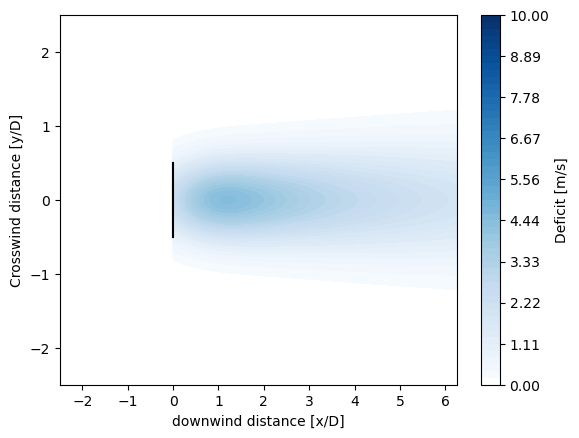

In [13]:
from py_wake.deficit_models import CarbajofuertesGaussianDeficit
plot_wake_deficit_map(CarbajofuertesGaussianDeficit())

### TurboGaussianDeficit

Implemented similar to Ørsted's TurbOPark model (https://github.com/OrstedRD/TurbOPark)

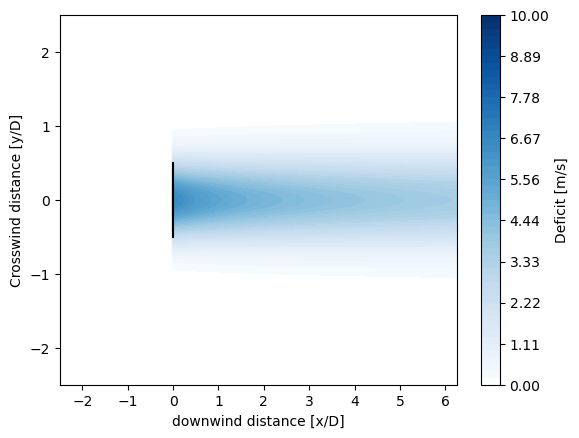

In [14]:
from py_wake.deficit_models import TurboGaussianDeficit
plot_wake_deficit_map(TurboGaussianDeficit())

### GCLDeficit

**Implemented according to:**

Larsen, G. C. (2009). A simple stationary semi-analytical wake model, Risø National Laboratory for Sustainable Energy,  Technical University of Denmark. Denmark. Forskningscenter Risoe. Risoe-R, No. 1713(EN)

**Description:**

Based on an analytical solution of the thin shear layer approximation of the NS equations. The wake flow fields are assumed rotationally symmetric, and the rotor inflow fields are consistently assumed uniform. The effect of expansion is approximately accounted for by imposing suitable empirical downstream boundary conditions on the wake expansion that depend on the rotor thrust and the ambient turbulence conditions, respectively.

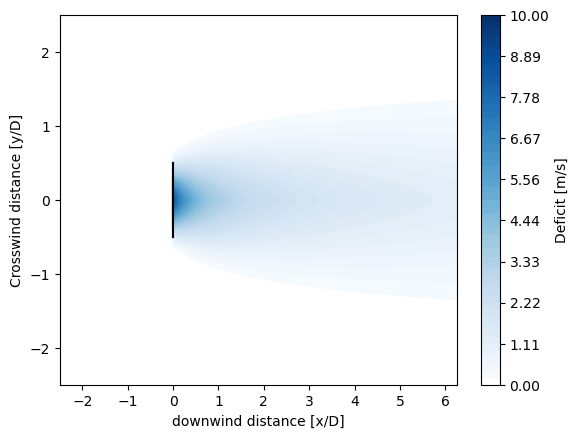

In [15]:
from py_wake.deficit_models import GCLDeficit
plot_wake_deficit_map(GCLDeficit())

### Comparing wake deficit models

In [16]:
#printing all available wake deficit models in PyWake
from py_wake.utils.model_utils import get_models
from py_wake.deficit_models import WakeDeficitModel

deficitModels = get_models(WakeDeficitModel)
for deficitModel in deficitModels:
    print (deficitModel.__name__)

NOJDeficit
FugaDeficit
FugaMultiLUTDeficit
FugaYawDeficit
BastankhahGaussianDeficit
CarbajofuertesGaussianDeficit
IEA37SimpleBastankhahGaussianDeficit
NiayifarGaussianDeficit
TurboGaussianDeficit
ZongGaussianDeficit
GCLDeficit
NoWakeDeficit
NOJLocalDeficit
TurboNOJDeficit


**1) Deficit along center line**

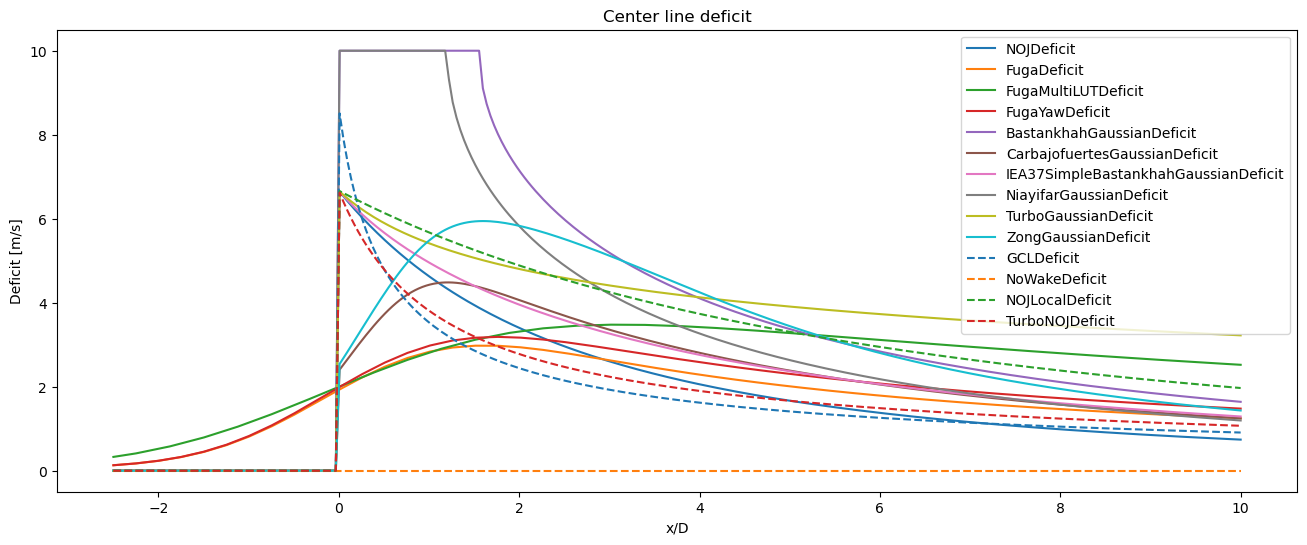

In [17]:
plt.figure(figsize=((16,6))) 
for i, deficitModel in enumerate(deficitModels):
    X, Y, deficit = _map(deficitModel(), xy=(np.linspace(-200,800,300), 0))
    plt.plot(X[0], deficit[0], ('-','--')[i//10], label=deficitModel.__name__)
plt.title("Center line deficit")
plt.xlabel('x/D')
plt.ylabel('Deficit [m/s]')
plt.legend()

**2) Deficit profile downstream**

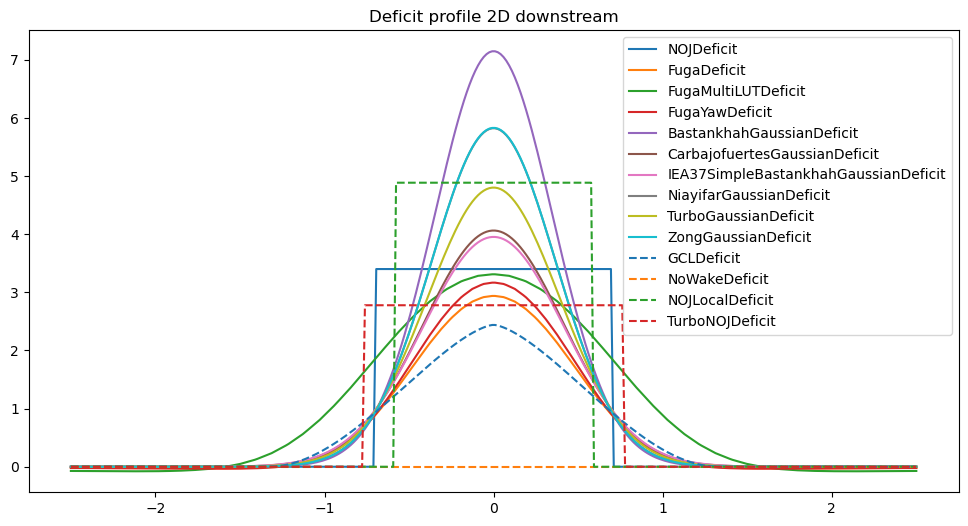

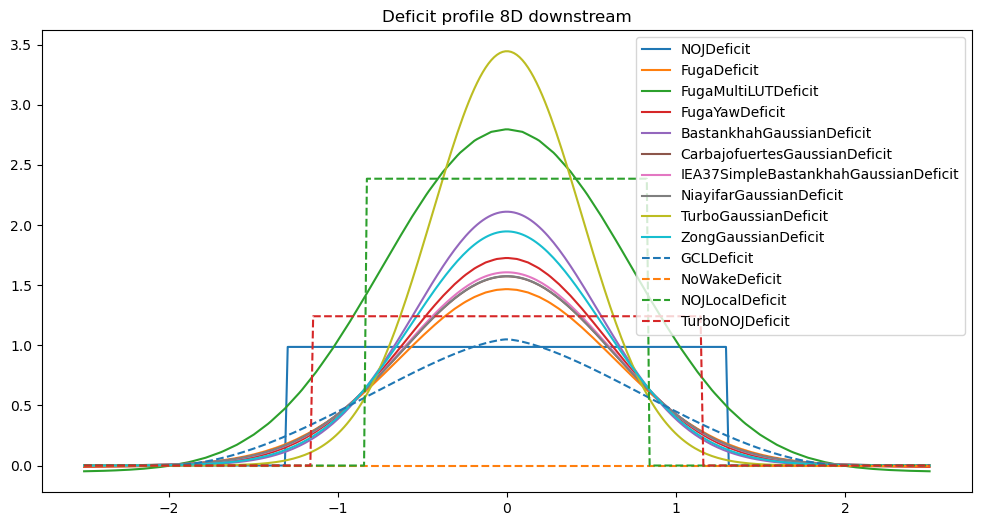

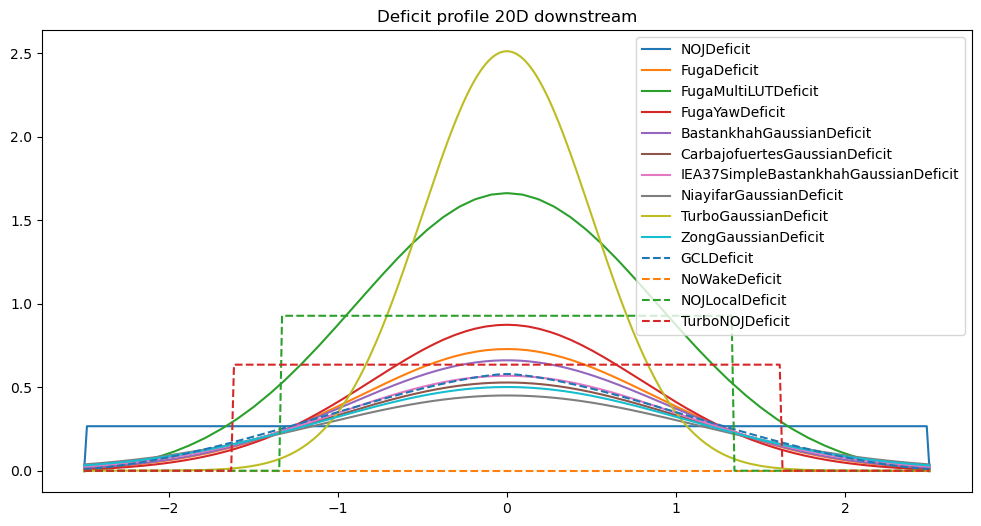

In [18]:
for d in 2,8,20:
    plt.figure(figsize=((12,6)))
    for i, deficitModel in enumerate(deficitModels):
        X, Y, deficit = _map(deficitModel(), xy=(d*D, np.linspace(-200,200,300)))
        plt.plot(Y[:,], deficit[:,0], ('-','--')[i//10], label=deficitModel.__name__)
    plt.title(f'Deficit profile {d}D downstream')
    plt.legend()

### You can also implement your own deficit models
Deficit models must subclass `DeficitModel`and thus must implement the `calc_deficit` method and a class variable, `args4deficit` specifying the arguments required by its `calc_deficit` method

```python 
class DeficitModel(ABC):
    args4deficit = ['WS_ilk', 'dw_ijlk']

    @abstractmethod
    def calc_deficit(self):
        """Calculate wake deficit caused by the x'th most upstream wind turbines
        for all wind directions(l) and wind speeds(k) on a set of points(j)

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deficit

        See class documentation for examples and available arguments

        Returns
        -------
        deficit_ijlk : array_like
        """
```

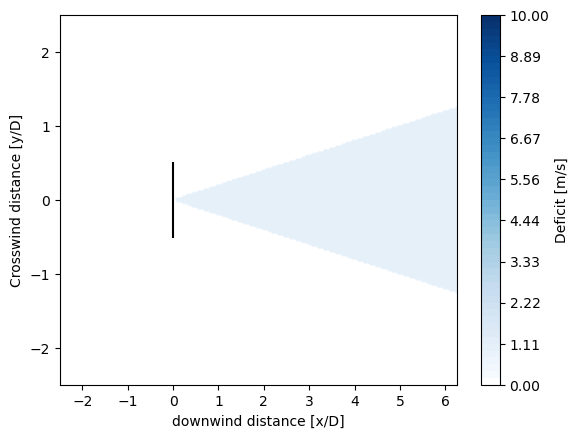

In [19]:
from py_wake.deficit_models import WakeDeficitModel
from numpy import newaxis as na
class MyDeficitModel(WakeDeficitModel):

    def calc_deficit(self, WS_ilk, dw_ijlk, cw_ijlk,**_):
        # 10% deficit in downstream triangle
        ws_10pct_ijlk = 0.1*WS_ilk[:,na]
        triangle_ijlk = ((.2*dw_ijlk) >cw_ijlk)
        return ws_10pct_ijlk *triangle_ijlk

plot_wake_deficit_map(MyDeficitModel())

## Superposition models
**The superposition models calculate the effective wind speed given the local wind speed and deficits (typically from multiple sources)**

There are three different superposition models in PyWake:

- [LinearSum](#LinearSum): Deficits sum up linearly.
- [SquaredSum](#SquaredSum): Deficits sum as root-sum-square.
- [MaxSum](#MaxSum): Only the largest deficit is considered.

### LinearSum

In general, LinearSum should be used in combination with `use_effective_ws=True` which makes downstream wind turbines feel the effective wind speed (including wake effects from upstream turbines) instead of the ambient free-stream wind speed. Otherwise negative wind speeds may occur.

Text(0, 0.5, 'y [m]')

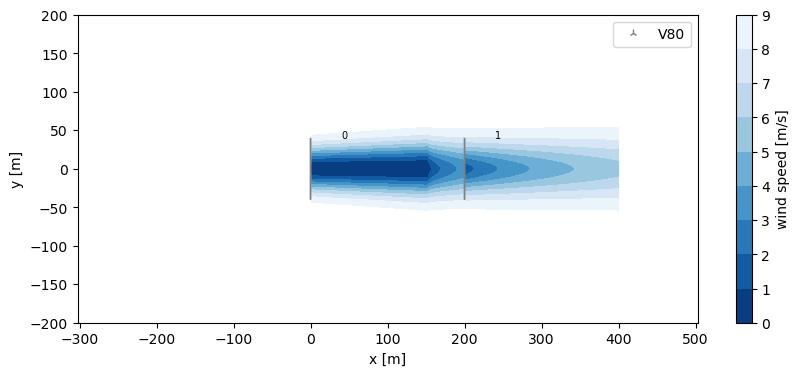

In [21]:
linear_sum = BastankhahGaussian(site, windTurbines, superpositionModel=LinearSum(), use_effective_ws=True)
plt.figure(figsize=(10,4))
linear_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### SquaredSum

The SquaredSum model is often used in combination with wake deficit models where the downstream wakes are scaled with the ambient free-stream velocity to avoid negative wind speeds. It is, however, a method to compensate for an inconsistent formulation, see section 2.2 in https://backend.orbit.dtu.dk/ws/portalfiles/portal/151671395/Park2_Documentation_and_Validation.pdf

Text(0, 0.5, 'y [m]')

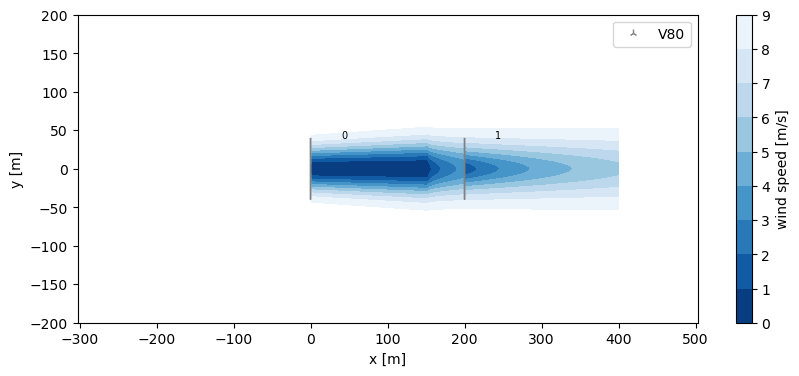

In [23]:
from py_wake.superposition_models import SquaredSum
squared_sum = BastankhahGaussian(site, windTurbines, superpositionModel=SquaredSum())
plt.figure(figsize=(10,4))
squared_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### MaxSum

Text(0, 0.5, 'y [m]')

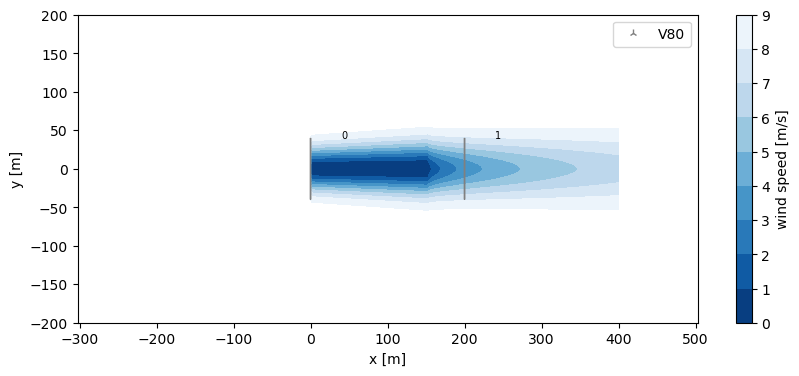

In [24]:
from py_wake.superposition_models import MaxSum
max_sum = BastankhahGaussian(site, windTurbines, superpositionModel=MaxSum())
plt.figure(figsize=(10,4))
max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

## Blockage deficit models

**The blockage deficit models compute the blockage effects caused by a single wind turbine.**

Their structure are quite similar to the [wake deficit models](#Wake-deficit-models). They model upstream blockage effects (wind speed reduction) and in addition, some models also models downstream speed-up effects. There are several blockage models available, which include:

- [SelfSimilarityDeficit](#SelfSimilarityDeficit)
- [SelfSimilarityDeficit2020](#SelfSimilarityDeficit2020)
- [FugaDeficit](#FugaDeficit)
- [VortexCylinder](#VortexCylinder)
- [VortexDipole](#VortexDipole)
- [RankineHalfBody](#RankineHalfBody)
- [HybridInduction](#HybridInduction)
- [Rathmann](#Rathmann)

### SelfSimilarityDeficit
Simple induction model, described in [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137)

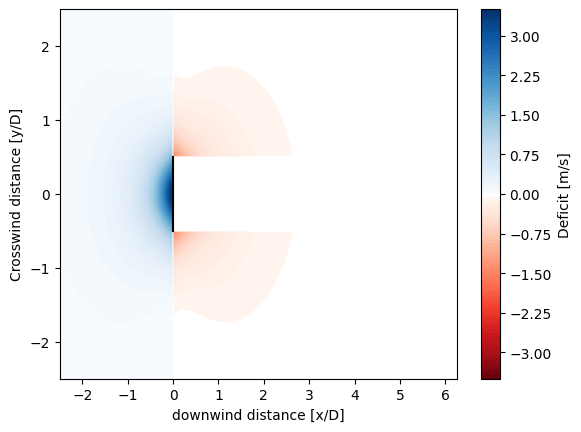

In [24]:
from py_wake.deficit_models import SelfSimilarityDeficit
plot_blockage_deficit_map(SelfSimilarityDeficit())

### SelfSimilarityDeficit2020

This is an updated version of [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137). The new features are found in the radial and axial functions:

1. Radially Eq. (13) is replaced by a linear fit, which ensures the induction half width, `r12`, to continue to diminish approaching the rotor. This avoids unphysically large lateral induction tails, which could negatively influence wind farm simulations.
2. The value of gamma in Eq. (8) is revisited. Now gamma is a function of CT and axial coordinate to force the axial induction to match the simulated results more closely. The fit is valid over a larger range of thrust coefficients and the results of the constantly loaded rotor are excluded in the fit.

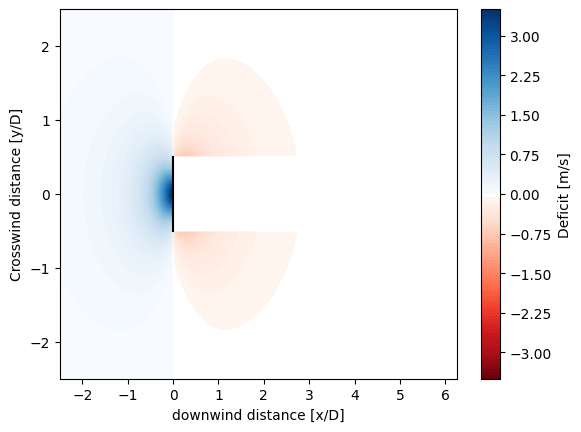

In [25]:
from py_wake.deficit_models import SelfSimilarityDeficit2020
plot_blockage_deficit_map(SelfSimilarityDeficit2020())

### FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set op look-up tables computed by a linearized RANS solver. The look-up tables be created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The FugaDeficit models the near wake, far wake and blockage deficit effects.

Note, the present look-up table generator introduces some unphysical wriggles in the blockage deficit/speed-up.

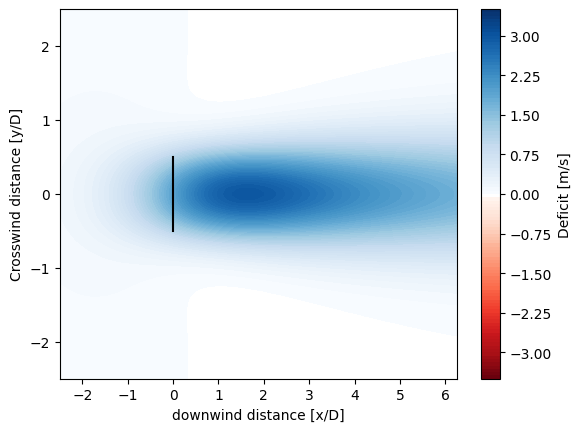

In [26]:
from py_wake.deficit_models import FugaDeficit
plot_blockage_deficit_map(FugaDeficit())

### VortexCylinder

Induced velocity from a semi-infinite cylinder of tangential vorticity, extending along the z axis.

This model is an adapted version of the one published by Emmanuel Branlard at https://github.com/ebranlard/wiz/blob/master/wiz/VortexCylinder.py

References:

- E. Branlard, M. Gaunaa, Cylindrical vortex wake model: right cylinder, Wind Energy, 2014, https://onlinelibrary.wiley.com/doi/full/10.1002/we.1800
- E. Branlard, Wind Turbine Aerodynamics and Vorticity Based Method, Springer, 2017
- E. Branlard, A. Meyer Forsting, Using a cylindrical vortex model to assess the induction zone in front of aligned and yawed rotors, in Proceedings of EWEA Offshore Conference, 2015, https://orbit.dtu.dk/en/publications/using-a-cylindrical-vortex-model-to-assess-the-induction-zone-inf

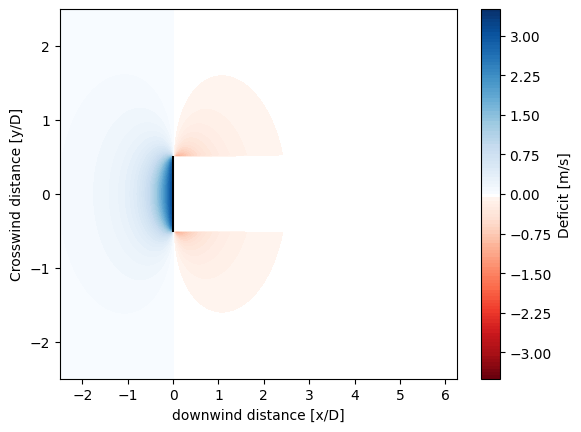

In [27]:
from py_wake.deficit_models import VortexCylinder
plot_blockage_deficit_map(VortexCylinder())

### VortexDipole

The vorticity originating from a wind turbine can be represented by a vortex dipole line (see Appendix B in [2]). The induction estimated by such a representation is very similar to the results given by the more complex vortex cylinder model in the far-field r/R > 6 [1,2]. The implementation follows the relationships given in [1,2]. This model is an adapted version of the one published by Emmanuel Branlard: https://github.com/ebranlard/wiz/blob/master/wiz/VortexDoublet.py

References:
- [1] Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
- [2] Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086.  https://doi.org/10.1002/we.2546

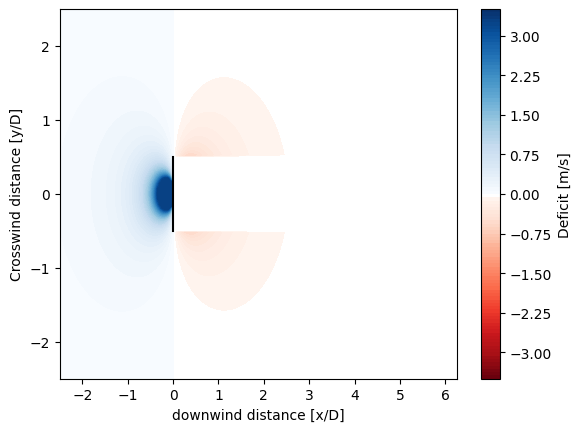

In [28]:
from py_wake.deficit_models import VortexDipole
plot_blockage_deficit_map(VortexDipole())

### RankineHalfBody

A simple induction model using a Rankine Half Body to represent the induction introduced by a wind turbine. The source strength is determined enforcing 1D momentum balance at the rotor disc.

References:

- B Gribben, G Hawkes - A potential flow model for wind turbine induction and wind farm blockage - Technical Paper, Frazer-Nash Consultancy, 2019

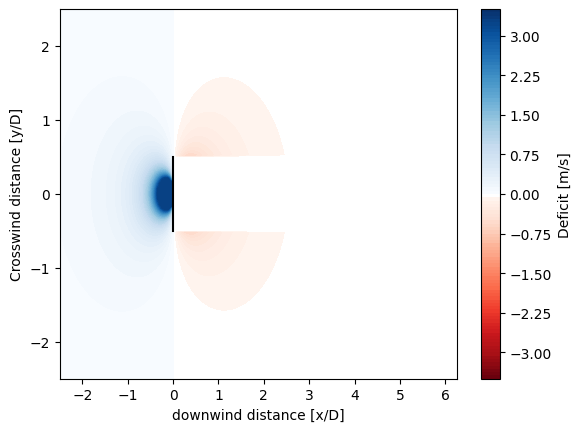

In [29]:
from py_wake.deficit_models import RankineHalfBody
plot_blockage_deficit_map(RankineHalfBody())

### HybridInduction
The idea behind this model originates from [2,3], which advocates to combine near-rotor and farfield approximations of a rotor's induced velocities. Whereas in [1,2] the motivation is to reduce the computational effort, here the already very fast self-similar model [1] is combined with the vortex dipole approximation in the far-field, as the self-similar one is optimized for the near-field (r/R > 6, x/R < 1) and misses the acceleration around the wake for x/R > 0. The combination of both allows capturing the redistribution of energy by blockage. Location at which to switch from near-rotor to far-field can be altered though by setting switch_radius.

References:
1. N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016
2. Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
3. Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086. https://doi.org/10.1002/we.2546

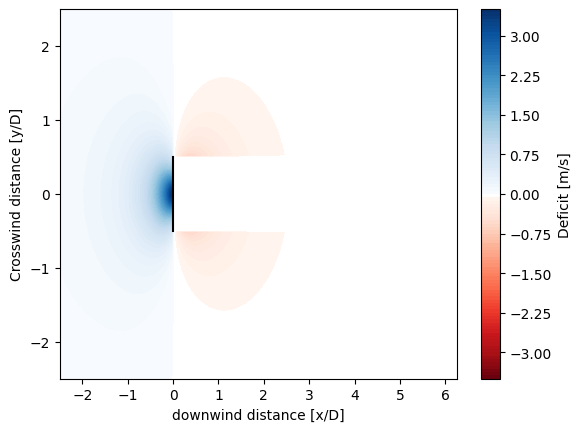

In [30]:
from py_wake.deficit_models import HybridInduction
plot_blockage_deficit_map(HybridInduction())

### Rathmann

Ole Sten Rathmann (DTU) developed in 2020 an approximation to the vortex cylinder solution (E. Branlard and M. Gaunaa, 2014). In speed it is comparable to the vortex dipole method, whilst giving a flow-field nearly identical to the vortex cylinder model for x/R < -1. Its centreline deficit is identical to the vortex cylinder model, whilst using a radial shape function that depends on the opening of the vortex cylinder seen from a point upstream. To simulate the speed-up downstream the deficit is mirrored in the rotor plane with a sign change.

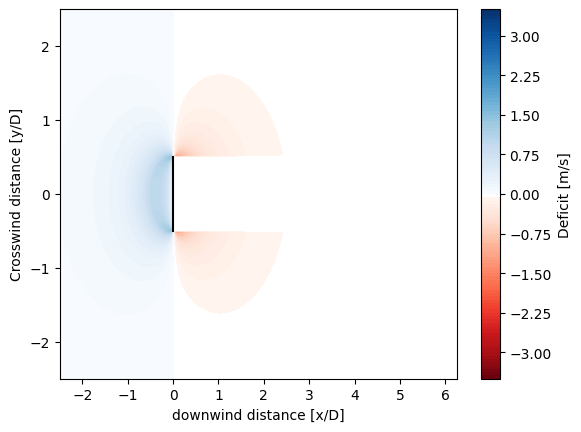

In [31]:
from py_wake.deficit_models import Rathmann
plot_blockage_deficit_map(Rathmann())

### Comparing different blockage deficit models

In [32]:
blockagedeficitModels = [SelfSimilarityDeficit(),
                 SelfSimilarityDeficit2020(),
                 FugaDeficit(),
                 VortexCylinder(),
                 VortexDipole(),
                 RankineHalfBody(),
                 HybridInduction(),
                 Rathmann()]

**1) Deficit along center line**

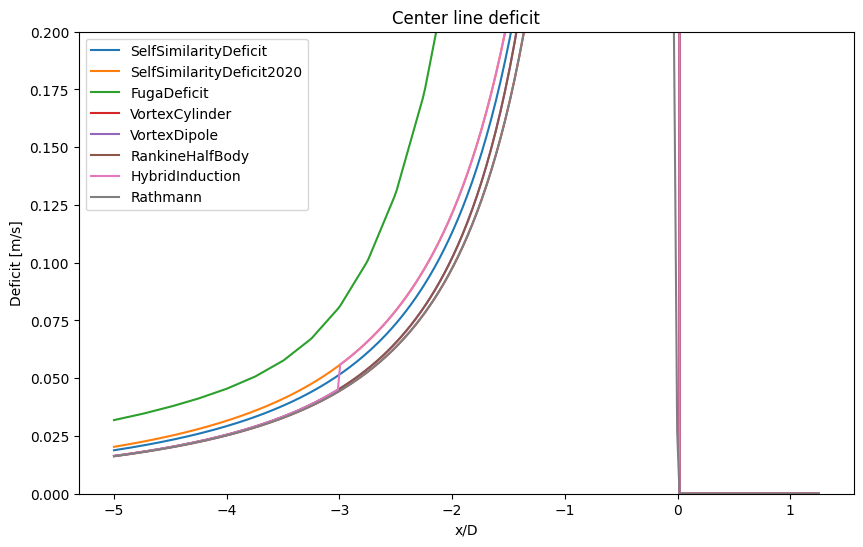

In [33]:
plt.figure(figsize=((10,6)))
for deficitModel in blockagedeficitModels:
    X, Y, deficit = _map(deficitModel, xy=(np.linspace(-400,100,300), 0))
    plt.plot(X[0], deficit[0], label=deficitModel.__class__.__name__)
plt.title("Center line deficit")
plt.xlabel('x/D')
plt.ylabel('Deficit [m/s]')
plt.ylim([0,.2])
plt.legend()

**2) Deficit profile 1 up- and downstream**

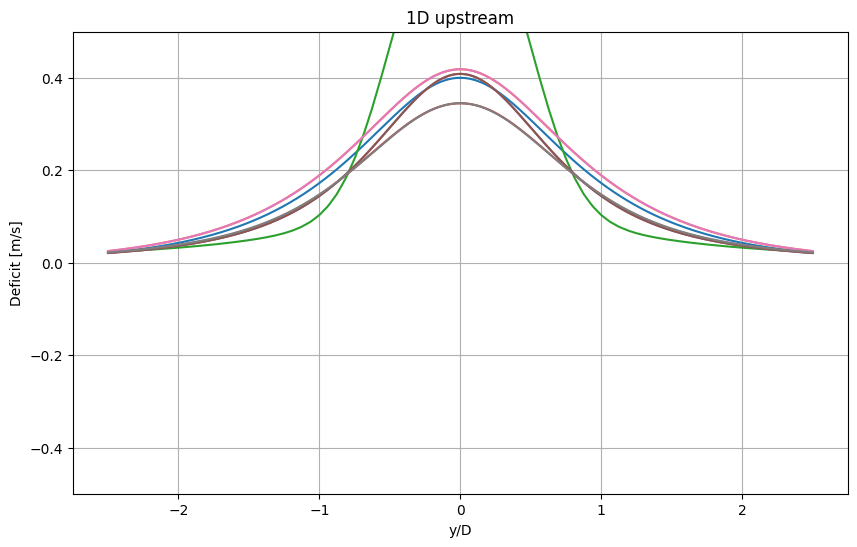

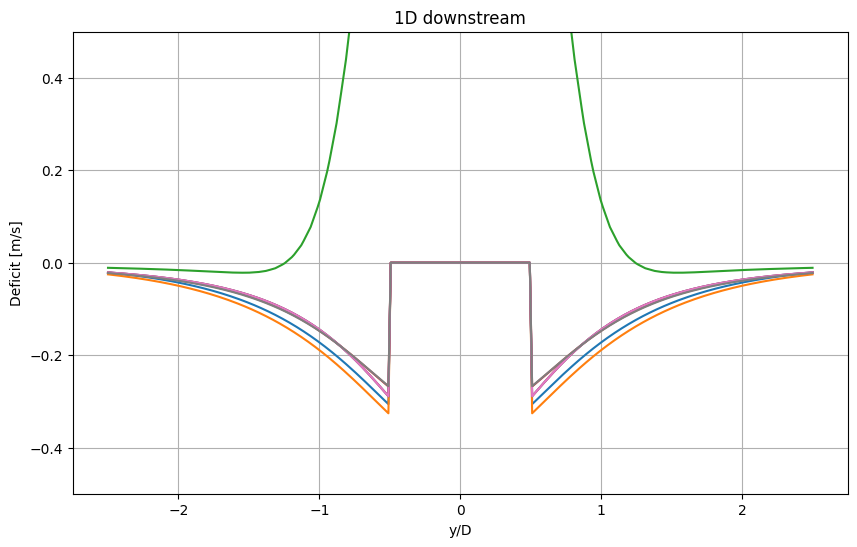

In [34]:
for d in [-1,1]:
    plt.figure(figsize=((10,6)))
    for deficitModel in blockagedeficitModels:
        X, Y, deficit = _map(deficitModel, xy=(d*D, np.linspace(-200,200,300)))
        plt.plot(Y[:,], deficit[:,0], label=deficitModel.__class__.__name__)
    plt.title("%sD %sstream"%(abs(d),('down','up')[d<0]))
    plt.ylim([-.5,.5])
    plt.xlabel('y/D')
    plt.ylabel('Deficit [m/s]')
    plt.legend
    plt.grid()

## Rotor-average models

In the plots below, it is clearly seen that the wind speed varies over the rotor, and that the the rotor-average wind speed is not well-defined by the wind sped at the rotor center. The rotor average model in PyWake defines one or more points at the turbine rotor to calculate a (weighted) rotor-average deficit. It includes:

- [RotorCenter](#RotorCenter): One point at the center of the rotor
- [GridRotorAvg](#GridRotorAvg): Custom grid in Cartesian coordinates'
- [EqGridRotorAvg](#EqGridRotorAvg): Equidistant N x N Cartesian grid covering the rotor
- [GQGridRotorAvg](#GQGridRotorAvg): M x N cartesian grid using Gaussian quadrature coordinates and weights
- [PolarGridRotorAvg](#PolarGridRotorAvg): Custom grid in polar coordinates  
- [CGIRotorAVG](#CGIRotorAvg): Circular Gauss Integration

Text(0, 0.5, 'Wind speed [m/s]')

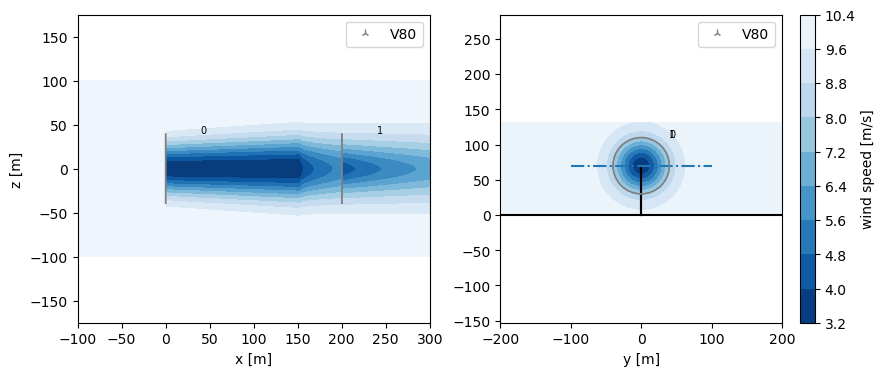

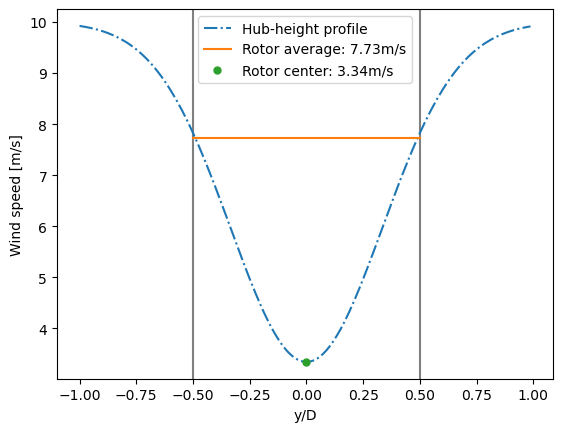

In [27]:
from py_wake.superposition_models import SquaredSum
from py_wake.flow_map import HorizontalGrid, YZGrid

R = D/2
wfm = BastankhahGaussian(site, windTurbines, superpositionModel=SquaredSum())
sim_res = wfm([0,200],[0,0],wd=270,ws=10)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_xlabel("x [m]"), ax1.set_ylabel("y [m]")
sim_res.flow_map(HorizontalGrid(extend=.1)).plot_wake_map(10, ax=ax1, plot_colorbar=False)
sim_res.flow_map(YZGrid(x=199.99)).plot_wake_map(10, ax=ax2)
ax2.plot([-100,100],[70,70],'-.')
ax2.set_xlabel("y [m]"), ax1.set_ylabel("z [m]")

plt.figure()
flow_map = sim_res.flow_map(HorizontalGrid(x=[199.99], y=np.arange(-80, 80)))

for x in [-.5,.5]:
    plt.gca().axvline(x,color='grey')
plt.plot(flow_map.Y[:, 0]/D, flow_map.WS_eff_xylk[:, 0, 0, 0], '-.', label='Hub-height profile')
plt.plot([-.5,.5],[7.73,7.73],label='Rotor average: 7.73m/s')
rc_ws = flow_map.WS_eff_xylk[80, 0, 0, 0]
plt.plot(flow_map.Y[80, 0]/D, rc_ws,'.', ms=10, label='Rotor center: %.2fm/s'%rc_ws)
plt.legend()
plt.xlabel("y/D")
plt.ylabel('Wind speed [m/s]')

First we create a simple function to model all of the rotor-average models available in PyWake.

In [33]:
from py_wake.rotor_avg_models import RotorCenter, GridRotorAvg, EqGridRotorAvg, GQGridRotorAvg, CGIRotorAvg, PolarGridRotorAvg, polar_gauss_quadrature, GaussianOverlapAvgModel
from py_wake.flow_map import HorizontalGrid

R=D/2

def plot_rotor_avg_model(rotorAvgModel, name):
    plt.figure()
    m = rotorAvgModel
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=m)
    ws_eff = wfm([0, 200], [0, 0], wd=270, ws=10).WS_eff_ilk[1,0,0]
    plt.title(name)
    c = plt.scatter(m.nodes_x, m.nodes_y,c=m.nodes_weight,label="%.2fm/s"%(ws_eff))
    plt.colorbar(c,label='weight')
    plt.gca().add_artist(plt.Circle((0,0),1,fill=False))
    plt.axis('equal')
    plt.xlabel("y/R [m]"); plt.ylabel('z/R [m]')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.legend()

### RotorCenter
Setting `rotorAvgModel=None` determines the rotor average wind speed from the rotor center point. Alternatively, you can use the `RotorCenter` model which is equivalent.

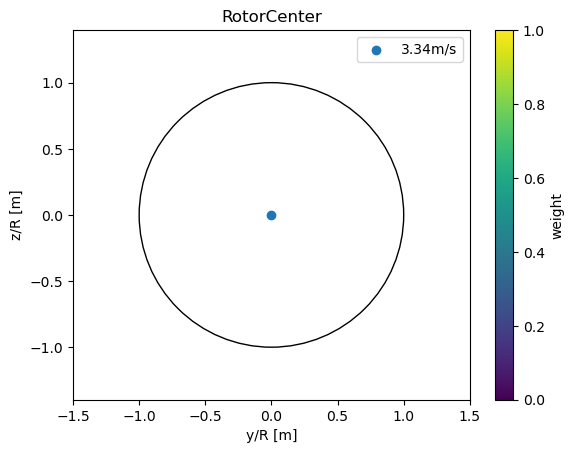

In [29]:
plot_rotor_avg_model(RotorCenter(), 'RotorCenter')

### GridRotorAvg

The `GridRotorAvg` defines a set of points in cartesian coordinates.

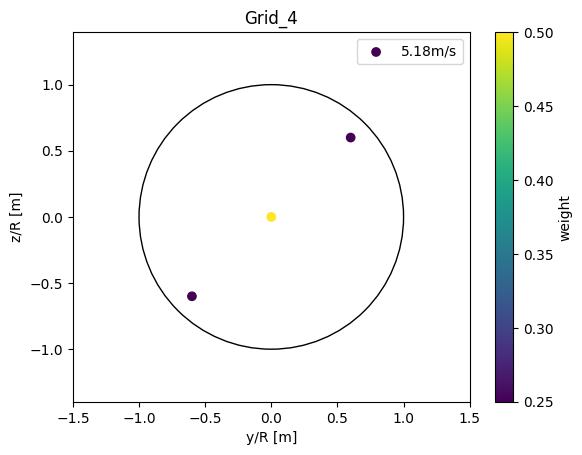

In [38]:
x = y = np.array([-.6, 0,.6])
plot_rotor_avg_model(GridRotorAvg(x,y,nodes_weight = [0.25,.5,.25]), 'Grid_4')

### EqGridRotorAvg

The `EqGridRotorAvg` defines a NxN equidistant cartesian grid of points and discards points outside the rotor.

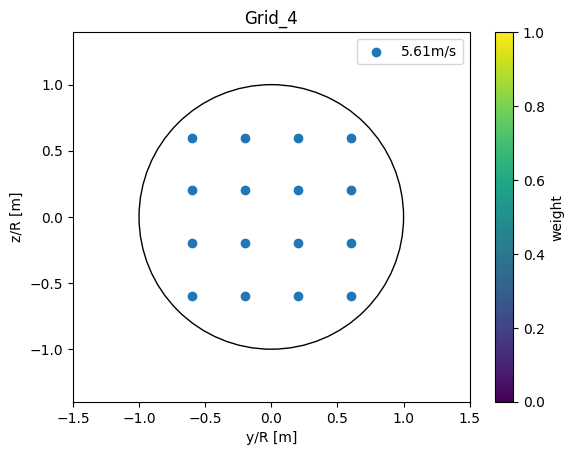

In [39]:
plot_rotor_avg_model(EqGridRotorAvg(4), 'Grid_4')

### GQGridRotorAvg

The `GQGridRotorAvg` defines a grid of M x N cartesian grid points using Gaussian quadrature coordinates and weights.

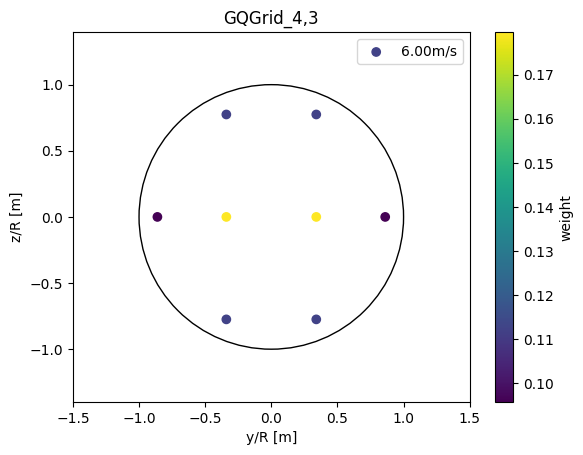

In [40]:
plot_rotor_avg_model(GQGridRotorAvg(4,3), 'GQGrid_4,3')

### PolarGridRotorAvg

The `PolarGridRotorAvg` defines a grid in polar coordinates.

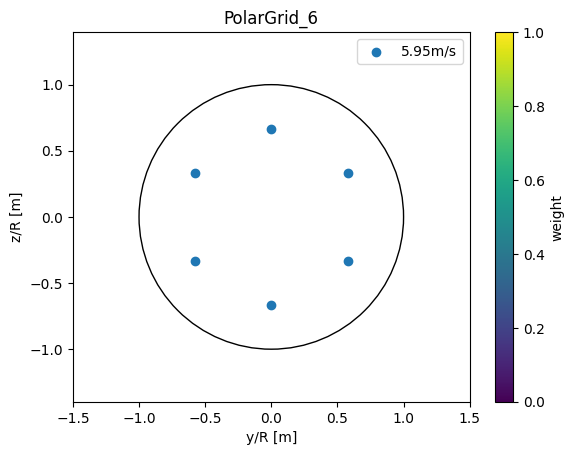

In [41]:
theta = np.linspace(-np.pi,np.pi,6, endpoint=False)
r = 2/3
plot_rotor_avg_model(PolarGridRotorAvg(nodes_r =r, nodes_theta=theta, nodes_weight=None), 'PolarGrid_6')

**The polar grid can be combined with Gaussian Quadrature.** 

This is similar to the implementation in FusedWake: https://gitlab.windenergy.dtu.dk/TOPFARM/FUSED-Wake/-/blob/master/fusedwake/gcl/fortran/GCL.f

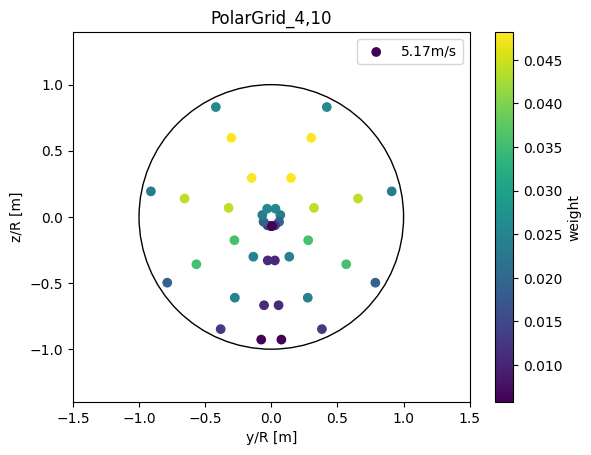

In [42]:
plot_rotor_avg_model(PolarGridRotorAvg(*polar_gauss_quadrature(4,10)), 'PolarGrid_4,10')

### CGIRotorAvg
Circular Gauss integration with 4,7,9 or 21 points as defined in Abramowitz M and Stegun A. Handbook of Mathematical Functions. Dover: New York, 1970.

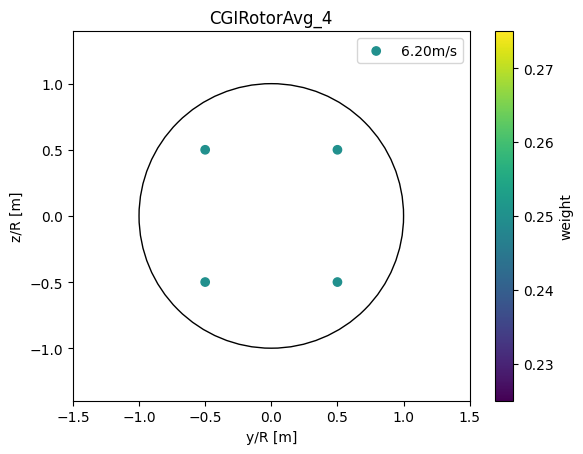

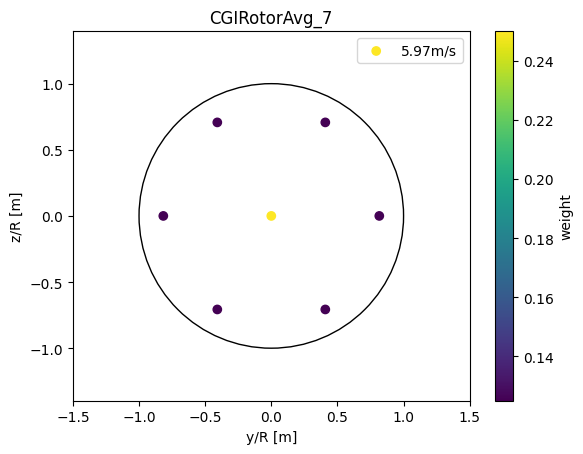

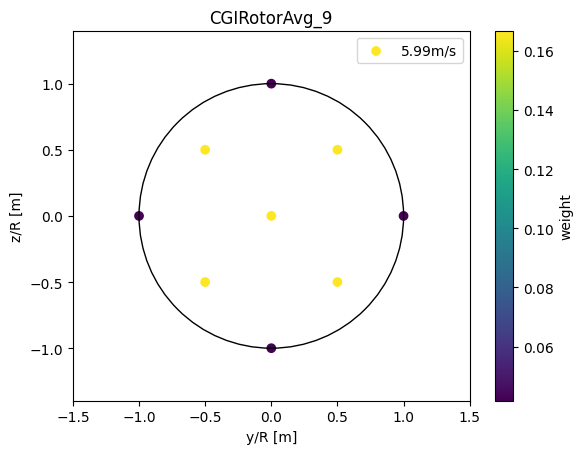

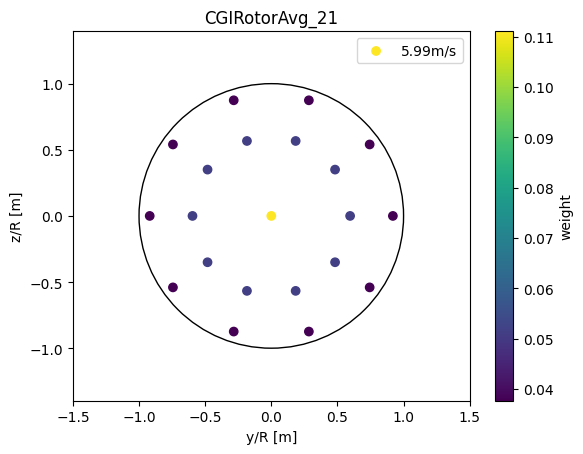

In [43]:
for n in [4,7,9,21]:
    plot_rotor_avg_model(CGIRotorAvg(n), 'CGIRotorAvg_%d'%n)

### AreaOverlapModel
The AreaOverlapModel calculates the fraction of the downstream rotor that is covered by the wake from an upstream wind turbine. This model makes sense for tophat wake deficit models only, e.g. NOJDeficit.


The calculation formula can be found in Eq. (A1) of  Feng, J., & Shen, W. Z. (2015). Solving the wind farm layout optimization problem using random search algorithm. Renewable Energy, 78, 182-192. https://doi.org/10.1016/j.renene.2015.01.005

<center><img src="images/AreaOverlap.svg" height=100px/></center>

### GaussianOverlapAvgModel

The GaussianOverlapModel computes the integral of the gaussian wake deficit over the downstream rotor. To speed up the computation, normalized integrals have been precalculated and stored in a look-up table. This model need the gaussian width parameter, $\sigma$, and therefore only applies to gaussian wake deficit models. 
See Appendix A in https://github.com/OrstedRD/TurbOPark/blob/main/TurbOPark%20description.pdf

<center><img src="images/GaussianOverlap.svg" height=100px/></center>

### Comparing rotor-average models
In general, the compuational cost and the accuracy of the estimate increases with the number of points, but the distribution of the points also has an impact.

The plot below shows the absolute error of the estimated rotor-average wind speed for the wind directions 
270 $\pm$ 30$^\circ$ (i.e. wind directions with more than 1% deficit) for a number of different rotor-average models.

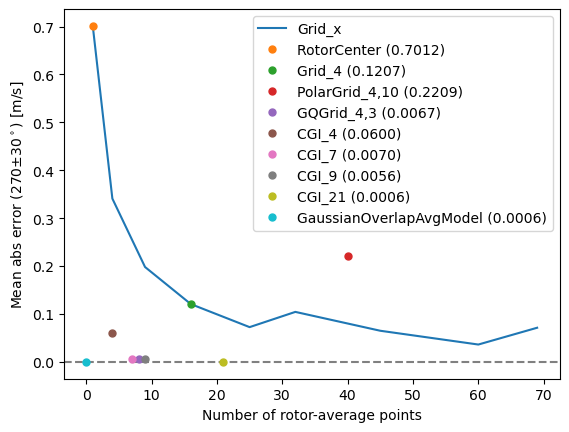

In [40]:
grid_models = [EqGridRotorAvg(i) for i in range(1,10)]
wd_lst = np.arange(240,301)

def get_ws_eff(rotorAvgModel):
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=rotorAvgModel)
    return wfm([0, 200], [0, 0], wd=wd_lst, ws=10).WS_eff_ilk[1,:,0]

ws_ref = get_ws_eff(EqGridRotorAvg(200)) # Use 200x200 points (31700 inside the rotor) to determine the reference value

def get_n_err(rotorAvgModel):
    ws_mean_err = np.abs(get_ws_eff(rotorAvgModel) - ws_ref).mean()
    return len(rotorAvgModel.nodes_x), ws_mean_err
        

plt.gca().axhline(0, color='grey',ls='--')
plt.plot(*zip(*[get_n_err(m) for m in grid_models]), label='Grid_x')
model_lst = [('RotorCenter', EqGridRotorAvg(1)),
             ('Grid_4', EqGridRotorAvg(4)),             
             ('PolarGrid_4,10', PolarGridRotorAvg(*polar_gauss_quadrature(4,10))),
             ('GQGrid_4,3', GQGridRotorAvg(4, 3))] + \
            [('CGI_%d'%n, CGIRotorAvg(n)) for n in [4,7,9,21]]
for name, model in model_lst:
    n,err = get_n_err(model)
    plt.plot(n,err,'.',ms=10, label="%s (%.4f)"%(name,err))
goam_err = np.abs(get_ws_eff(GaussianOverlapAvgModel()) - ws_ref).mean()
plt.plot([0],[goam_err],'.', ms=10, label="GaussianOverlapAvgModel (%.4f)"%(goam_err))
plt.xlabel('Number of rotor-average points')
plt.ylabel(r'Mean abs error (270$\pm30^\circ$) [m/s]')
plt.legend()

## Deflection models
**The deflection models calculate the deflection of the wake due to yaw-misalignment, sheared inflow etc.**

Note, this is one of the four effects of skew inflow that is handled in PyWake, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/YawMisalignment.html).

The deflection models take as input the downwind and crosswind distances between the source wind turbines and the destination wind turbines/sites and calculate a new set of deflected downwind and crosswind distances. This type of model is important for simulations where the turbine experiences a change in angle between the incoming flow and the rotor, for example in active yaw control or wake steering optimization.

In PyWake, there are three different wake deflection models:

- [JimenezWakeDeflection](#JimenezWakeDeflection)
- [FugaDeflection](#FugaDeflection)
- [GCLHillDeflection](#GCLHillDeflection)

First we create a simple function to plot the different deflection models available in PyWake.

In [45]:
def plot_deflection(deflectionModel):
    from py_wake import BastankhahGaussian
    from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37_WindTurbines

    site = IEA37Site(16)
    x, y = [0, 400, 800], [0, 0, 0]
    windTurbines = V80()
    wfm = BastankhahGaussian(site, windTurbines, deflectionModel=deflectionModel)

    yaw = [-20,20,0]
    D = windTurbines.diameter()

    plt.figure(figsize=(14,4))
    fm = wfm(x, y, yaw=yaw, tilt=0, wd=270, ws=10).flow_map()
    fm.plot_wake_map(normalize_with=D)
    center_line = fm.min_WS_eff()
    plt.plot(center_line.x/D, center_line/D,'--k')
    plt.grid()

### JimenezWakeDeflection

The `JimenezWakeDeflection` model is implemented according to Jiménez, Á., Crespo, A. and Migoya, E. (2010), Application of a LES technique to characterize the wake deflection of a wind turbine in yaw. Wind Energ., 13: 559-572. doi:10.1002/we.380.

It is the most common wake deflection model used in PyWake and has proved to result in a decent representation of the skewed inflow behind the turbine rotor. In the study, the authors carried out a Large Eddy Simulation (LES) to characterize the turbulence behind a wind turbine given the wake deflection created by different yaw angle and thrust coefficient settings.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

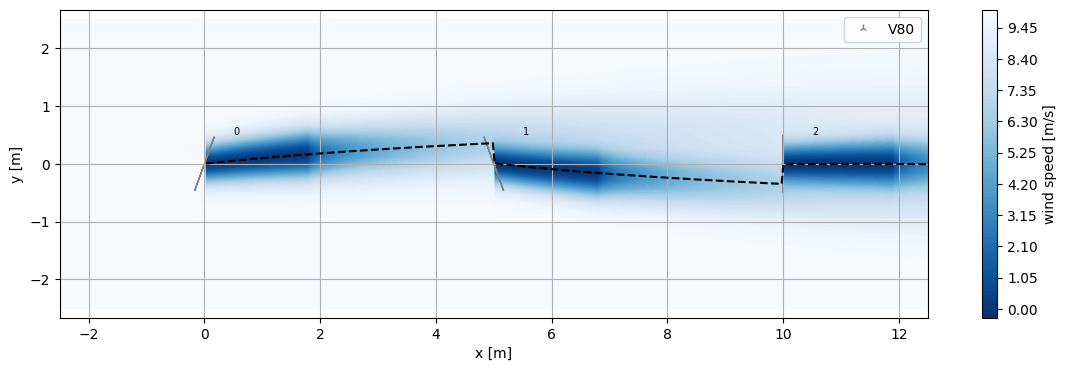

In [46]:
from py_wake.deflection_models import JimenezWakeDeflection
plt.figure()
plot_deflection(JimenezWakeDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### FugaDeflection

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

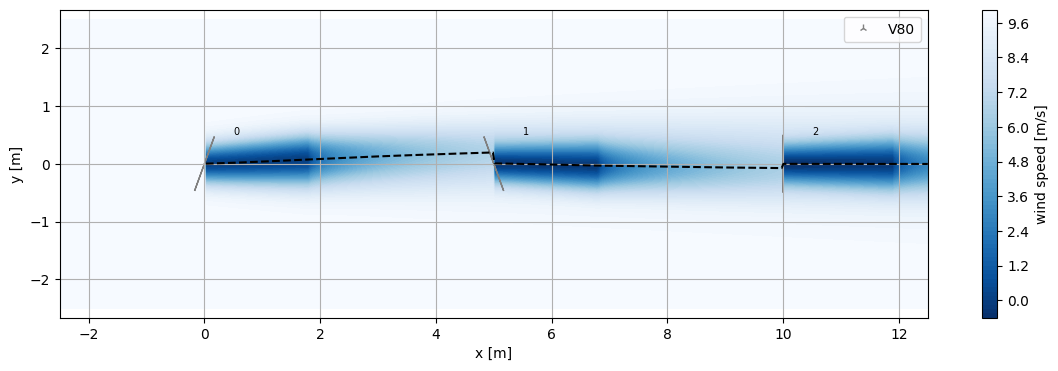

In [47]:
from py_wake.deflection_models import FugaDeflection
plt.figure()
plot_deflection(FugaDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### GCLHillDeflection

Deflection model based on Hill's ring vortex theory.

Implemented according to: Larsen, G. C., Ott, S., Liew, J., van der Laan, M. P., Simon, E., R.Thorsen, G., & Jacobs, P. (2020). Yaw induced wake deflection - a full-scale validation study. Journal of Physics - Conference Series, 1618, [062047]. https://doi.org/10.1088/1742-6596/1618/6/062047.
    
Note, this model uses the wake centerline deficit magnitude to calculate the deflection. Hence non-gaussian-shaped wake deficit models as well as deficit models with improper near wake fields, e.g. NOJDeficit, BastankhahGaussianDeficit, NiayifarGaussianDeficit, should be avoided.

As default the model uses the `WakeDeficitModel` specified for the `WindFarmModel` to calculate the magnitude of the deficit, but a separate model can be specified.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

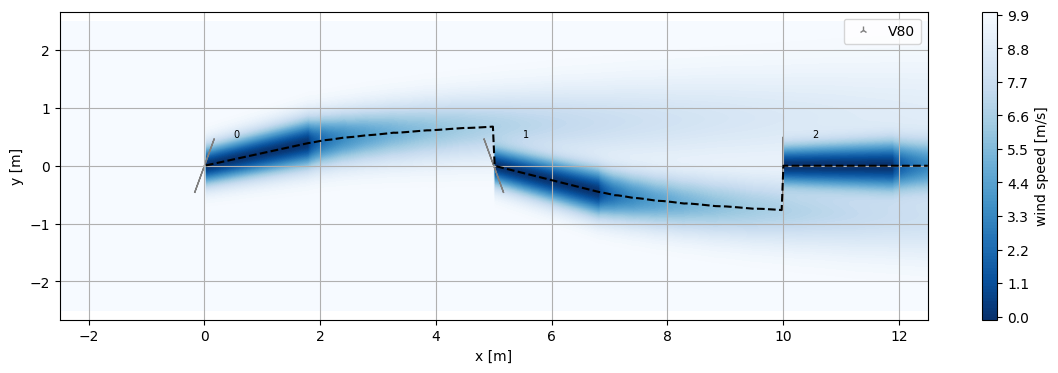

In [48]:
from py_wake.deflection_models import GCLHillDeflection
plt.figure()
plot_deflection(GCLHillDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### You can also implement your own deflection models

Deficit models must subclass `DeficitModel` and thus must implement the `calc_deflection` method and a class variable, `args4deflection` specifying the arguments required by its calc_deflection method.

```python

class DeflectionModel(ABC):
    args4deflection = ["ct_ilk"]

    @abstractmethod
    def calc_deflection(self, dw_ijl, hcw_ijl, **kwargs):
        """Calculate deflection

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deflection

        See documentation of EngineeringWindFarmModel for a list of available input arguments

        Returns
        -------
        dw_ijlk : array_like
            downwind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        hcw_ijlk : array_like
            horizontal crosswind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        """
```

Text(0, 0.5, 'y [m]')

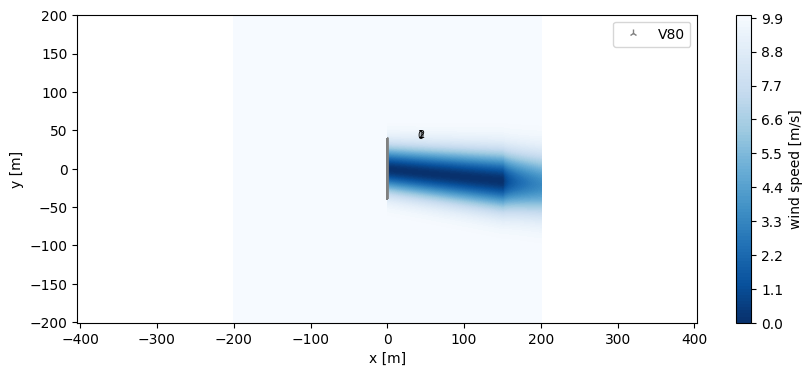

In [49]:
from py_wake.deflection_models import DeflectionModel
from numpy import newaxis as na

class MyDeflectionModel(DeflectionModel):

    def calc_deflection(self, dw_ijlk, hcw_ijlk, **_):
        hcw_ijlk =hcw_ijlk + .1*dw_ijlk       # deflect 1/10 of the downstream distance
        dh_ijlk =np.zeros_like(hcw_ijlk)      # no vertical deflection
        return dw_ijlk, hcw_ijlk, dh_ijlk

iea_my_deflection = BastankhahGaussian(site, windTurbines, deflectionModel=MyDeflectionModel())

plt.figure(figsize=(10,4))
iea_my_deflection(x, y, wd=270, ws=10).flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

## Turbulence models

The turbulence models in PyWake are used to calculate the added turbulence in the wake from one wind turbine to downstream turbines or sites in the wind farm. These are important when the flow properties behind the rotor must be accurately represented, for example for calculation of fatigue loading of turbine components.

First we create a simple function to plot the different turbulence models available in PyWake.

In [50]:
def plot_turb_map(turbulenceModel):
    xy = np.linspace(-200,500,200), np.linspace(-200,200,200)
    X,Y,deficit = _map(turbulenceModel, xy, '__call__')
    c = plt.contourf(X,Y,deficit, levels=100, cmap='Blues')
    plt.colorbar(c, label="Added turbulence intensity [-]")
    plt.plot([0,0],[-1/2,1/2],'k')
    plt.ylabel("Crosswind distance [y/D]")
    plt.xlabel("downwind distance [x/D]")

### STF2005TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2005 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

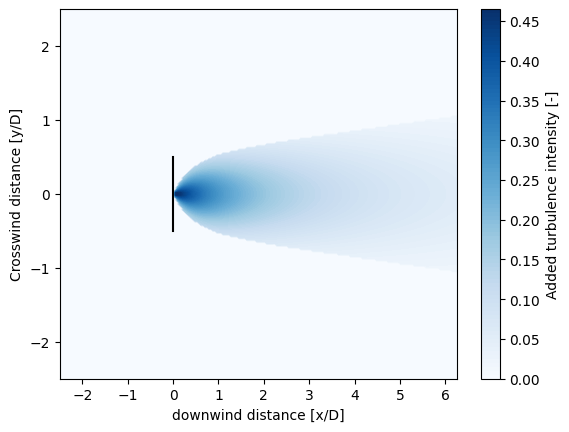

In [51]:
from py_wake.turbulence_models import STF2005TurbulenceModel
plot_turb_map(STF2005TurbulenceModel())

### STF2017TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2017 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

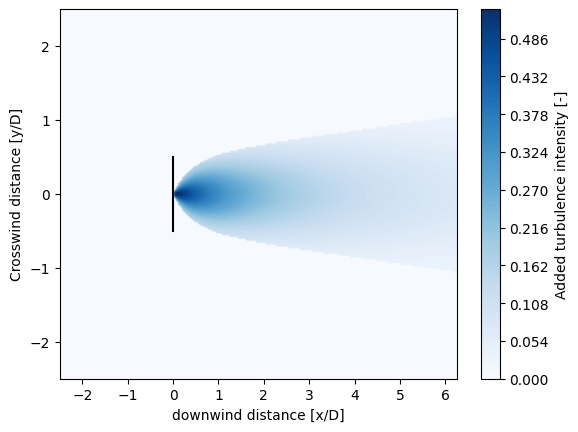

In [52]:
from py_wake.turbulence_models import STF2017TurbulenceModel
plot_turb_map(STF2017TurbulenceModel())

**STF20XXTurbulenceModel with IEC-based spread angle**

The `STF2005TurbulenceModel` and `STF2017TurbulenceModel` take a `weight_function` input which defaults to the bell-shaped `FrandsenWeight` defined in Steen Frandsen's thesis. As an alternative the `IECWeight` applies the full added turbulence in a 21.6$^\circ$ spread angle up to 10 diameter downstream. 

Note, this is a debatable interpretation of the IEC standard which includes a 6% contribution from neighbouring wind turbines when calculating the omni-directional effective turbulence intensity. These 6% maps to a spread angle of 360$^\circ\cdot$ 6% = 21.6$^\circ$.

Note, the IEC standard includes more concepts which is not implemented in PyWake.

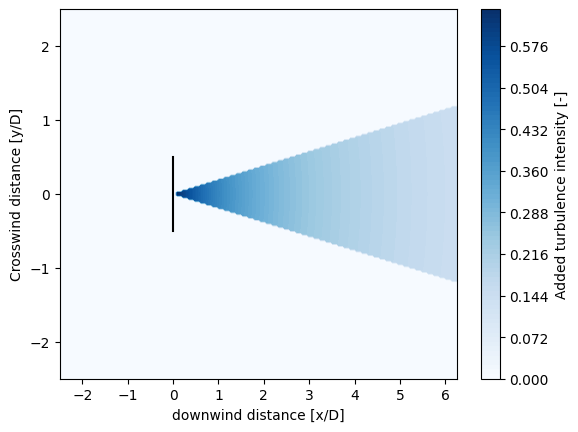

In [53]:
from py_wake.turbulence_models import STF2017TurbulenceModel, IECWeight
from py_wake.superposition_models import SqrMaxSum
plot_turb_map(STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=SqrMaxSum(), 
                                     weight_function=IECWeight(distance_limit=10)))

### GCLTurbulence

Gunner Chr. Larsen model implemented according to:
    
Pierik, J. T. G., Dekker, J. W. M., Braam, H., Bulder, B. H., Winkelaar, D., Larsen, G. C., Morfiadakis, E., Chaviaropoulos, P., Derrick, A., & Molly, J. P. (1999). European wind turbine standards II (EWTS-II). In E. L. Petersen, P. Hjuler Jensen, K. Rave, P. Helm, & H. Ehmann (Eds.), Wind energy for the next millennium. Proceedings (pp. 568-571). James and James Science Publishers.

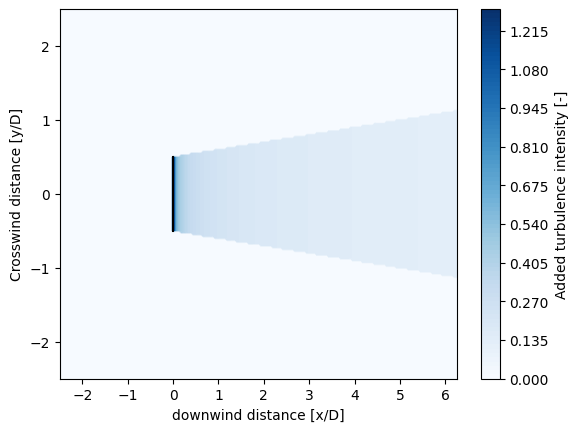

In [54]:
from py_wake.turbulence_models import GCLTurbulence
plot_turb_map(GCLTurbulence())

### CrespoHernandez

Implemented according to: A. Crespo and J. Hernández, Turbulence characteristics in wind-turbine wakes, J. of Wind Eng. and Industrial Aero. 61 (1996) 71-85.

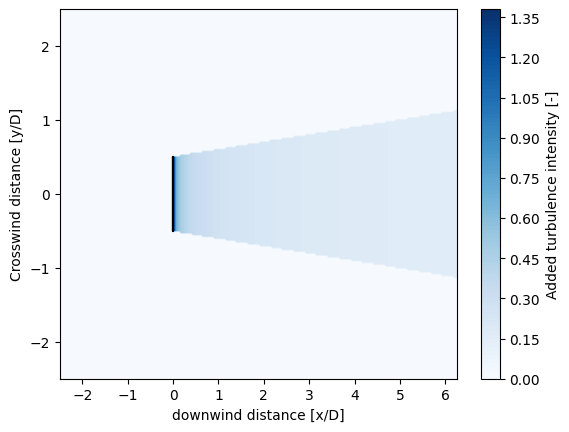

In [55]:
from py_wake.turbulence_models import CrespoHernandez
plot_turb_map(CrespoHernandez())

### Comparing turbulence models

In [56]:
turbulenceModels = [STF2005TurbulenceModel(),
                 STF2017TurbulenceModel(),
                 STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=SqrMaxSum(), weight_function=IECWeight(10)),
                 GCLTurbulence(),
                 CrespoHernandez()]

**1) Turbulence intensity along center line**

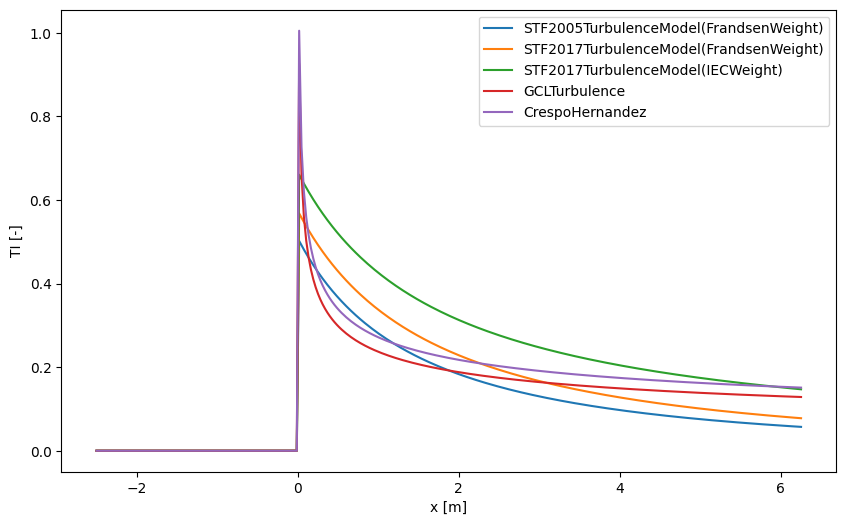

In [57]:
plt.figure(figsize=((10,6)))
for turbulenceModel in turbulenceModels:
    X, Y, ti = _map(turbulenceModel, xy=(np.linspace(-200,500,300), 0), method="calc_added_turbulence")
    l = turbulenceModel.__class__.__name__
    if l.startswith('STF'):
        l+=f"({turbulenceModel.apply_weight.__self__.__class__.__name__})"
    plt.plot(X[0], ti[0], label=l)
    plt.xlabel('x [m]')
    plt.ylabel('TI [-]')
plt.legend()

**2) Deficit profile 2D downstream**

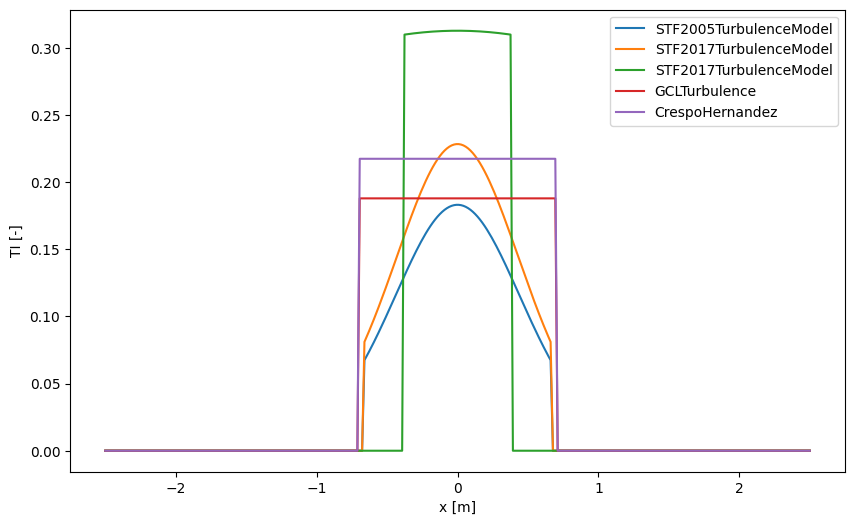

In [58]:
plt.figure(figsize=((10,6)))
for turbulenceModel in turbulenceModels:
    X, Y, ti = _map(turbulenceModel, xy=(2*D, np.linspace(-200,200,300)), method="calc_added_turbulence")
    plt.plot(Y[:,], ti[:,0], label=turbulenceModel.__class__.__name__)
    plt.xlabel('x [m]')
    plt.ylabel('TI [-]')
plt.legend()

## Ground models

The ground models in PyWake are used to model the effects that the ground has on the inflow and wake.

### Mirror
The Mirror ground model lets the ground mirror the wake deficit. It is implemented by adding wakes from underground mirrored wind turbines

Text(0, 0.5, 'y [m]')

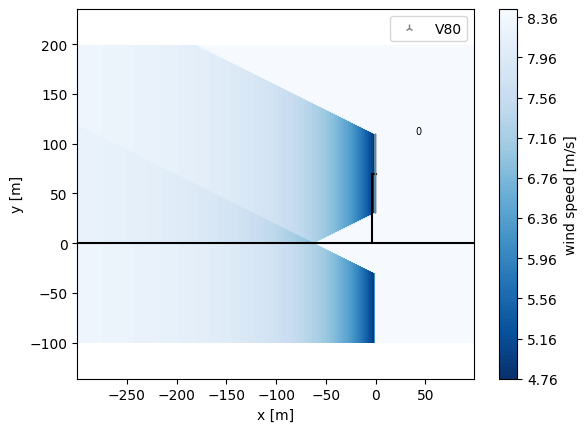

In [59]:
from py_wake.ground_models import Mirror
wfm = NOJ(site, windTurbines, k=.5, groundModel=Mirror())

plt.figure()
wfm([0], [0], wd=0).flow_map(YZGrid(x=0, y=np.arange(-300, 100, 1) + .1, z=np.arange(-100, 200))).plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')